In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets, transforms
# from torchvision.transforms import PILToTensor
from torch.utils.data import DataLoader, Dataset
import torchmetrics
from torchmetrics import Accuracy

import matplotlib.pyplot as plt
from pathlib import Path
import random
import kagglehub
import pandas
import numpy as np

from PIL import Image

import requests
import zipfile
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
device

/home/redux/Documents/PyTorch/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [2]:
# # Download latest version
# path = kagglehub.dataset_download("gpiosenka/sports-classification")

# print("Path to dataset files:", path)

In [3]:
# Setup path to data folder
data_path = Path("./")
image_path = data_path / "sports"

In [4]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [5]:
# walk_through_dir(image_path)

In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('sports/train'), PosixPath('sports/test'))

Random Image Path: sports/train/sidecar racing/012.jpg
Image Class: sidecar racing
Image height: 224
Image width: 224


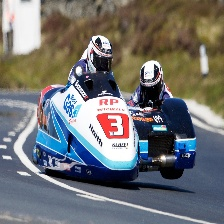

In [7]:
random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg")) # * (train, or test) / * (pizza, steak or sushi) / *.jpg (all the files ending in .jpg)

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random Image Path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

In [8]:
data_transform = transforms.Compose([
    transforms.Resize(size=(128, 128)),           # Resize the images to 128 x 128
    # transforms.RandomHorizontalFlip(p=0.5),     # The images have 50% chances to be horizontally flipped
    transforms.ToTensor()                       # Turn the image into a tensor
])

In [9]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 13492
     Root location: sports/train
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 500
     Root location: sports/test
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [10]:
class_names = train_data.classes
class_names, len(class_names)

(['air hockey',
  'ampute football',
  'archery',
  'arm wrestling',
  'axe throwing',
  'balance beam',
  'barell racing',
  'baseball',
  'basketball',
  'baton twirling',
  'bike polo',
  'billiards',
  'bmx',
  'bobsled',
  'bowling',
  'boxing',
  'bull riding',
  'bungee jumping',
  'canoe slamon',
  'cheerleading',
  'chuckwagon racing',
  'cricket',
  'croquet',
  'curling',
  'disc golf',
  'fencing',
  'field hockey',
  'figure skating men',
  'figure skating pairs',
  'figure skating women',
  'fly fishing',
  'football',
  'formula 1 racing',
  'frisbee',
  'gaga',
  'giant slalom',
  'golf',
  'hammer throw',
  'hang gliding',
  'harness racing',
  'high jump',
  'hockey',
  'horse jumping',
  'horse racing',
  'horseshoe pitching',
  'hurdles',
  'hydroplane racing',
  'ice climbing',
  'ice yachting',
  'jai alai',
  'javelin',
  'jousting',
  'judo',
  'lacrosse',
  'log rolling',
  'luge',
  'motorcycle racing',
  'mushing',
  'nascar racing',
  'olympic wrestling',
  

In [22]:
BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x71b5ef4b8590>,
 <torch.utils.data.dataloader.DataLoader at 0x71b5ef4b8440>)

In [12]:
len(train_dataloader), len(test_dataloader)

(422, 16)

In [13]:
img, label = next(iter(train_dataloader))

print(f"Image Shape: {img.shape} --> [batch size, color channels, height, width]")
print(f"Label Shape: {label.shape}")

Image Shape: torch.Size([32, 3, 128, 128]) --> [batch size, color channels, height, width]
Label Shape: torch.Size([32])


In [44]:
class TinyVGG(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=2,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 30 * 30,
                      out_features=output_shape)
        )
    
    def forward(self, x):
        # x = self.conv_layer_1(x)
        # print(x.shape)
        # x = self.conv_layer_2(x)
        # print(x.shape)
        # x = self.conv_layer_3(x)
        # print(x.shape)
        # x = self.classifier(x)
        # return x
        return self.classifier(self.conv_layer_2(self.conv_layer_1(x)))

In [14]:
class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super(VisionTransformer, self).__init__()
        assert image_size % patch_size == 0, "Image size must be divisible by patch size."
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2
        
        # Embedding layers
        self.patch_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.dropout = nn.Dropout(0.1)
        
        # Transformer Encoder
        self.transformer = nn.Transformer(
            d_model=dim, nhead=heads, num_encoder_layers=depth, dim_feedforward=mlp_dim
        )
        
        # Classification Head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )
    
    def forward(self, x):
        batch_size, _, _, _ = x.shape
        patches = x.unfold(2, 16, 16).unfold(3, 16, 16)
        patches = patches.contiguous().view(batch_size, -1, 16 * 16 * 3)  # Flatten patches
        x = self.patch_embedding(patches)
        
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.dropout(x)
        
        x = self.transformer(x, x)
        x = self.mlp_head(x[:, 0])
        return x

In [15]:
model_1 = VisionTransformer(image_size=128,
                            patch_size=16,
                            num_classes=len(class_names),
                            dim=768,
                            depth=12,
                            heads=12,
                            mlp_dim=3072,
                            channels=3).to(device)
model_1

/home/redux/Documents/PyTorch/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


VisionTransformer(
  (patch_embedding): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-11): 12 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (linear1): Linear(in_features=768, out_features=3072, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=3072, out_features=768, bias=True)
          (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): Transforme

In [16]:
model_0 = TinyVGG(input_shape=3,
                  hidden_units=16,
                  output_shape=len(class_names)).to(device)
model_0

NameError: name 'TinyVGG' is not defined

In [17]:
model_1(train_data[0][0].unsqueeze(dim=0).to(device))

tensor([[ 7.4946e-01, -3.5771e-01,  6.9232e-01,  3.5931e-01,  3.5536e-01,
         -9.6120e-01,  4.3841e-01,  1.4827e-02, -3.1346e-01,  4.6519e-02,
          6.9978e-01, -6.9935e-01,  8.9205e-01, -6.7259e-01, -7.2578e-01,
          6.8882e-01,  6.0969e-01, -2.1810e-01,  6.8536e-01,  2.6577e-01,
          6.9317e-01,  1.7771e-01, -4.6190e-01, -7.6744e-01,  4.3504e-01,
         -8.2204e-01,  4.5675e-01, -4.8915e-02, -2.5825e-01, -9.2838e-01,
         -8.3888e-01, -4.1965e-01,  2.1208e-01, -2.1463e-01, -5.1576e-01,
          9.1588e-01,  4.3589e-03,  4.6730e-04,  8.4258e-01,  3.0867e-01,
          6.9082e-01, -8.6315e-01, -4.2478e-01,  8.3577e-01, -4.8887e-01,
          9.1831e-02,  1.3701e+00,  3.7326e-01, -1.0153e+00,  1.1468e-02,
          7.5786e-01,  3.0529e-01,  8.6069e-01, -2.1912e-01, -9.8925e-02,
          3.0004e-01,  2.1172e-01,  4.5989e-01,  4.2768e-01,  5.4748e-01,
         -8.3832e-01, -5.8292e-01,  1.1676e+00,  4.0147e-01, -2.4938e-01,
          7.2245e-02, -9.1709e-01, -2.

In [18]:
from torchinfo import summary

summary(model=model_1,
        input_size=[1, 3, 128, 128])

Layer (type:depth-idx)                                  Output Shape              Param #
VisionTransformer                                       [1, 100]                  50,688
├─Linear: 1-1                                           [1, 64, 768]              590,592
├─Dropout: 1-2                                          [1, 65, 768]              --
├─Transformer: 1-3                                      [1, 65, 768]              --
│    └─TransformerEncoder: 2-1                          [1, 65, 768]              --
│    │    └─ModuleList: 3-1                             --                        85,054,464
│    │    └─LayerNorm: 3-2                              [1, 65, 768]              1,536
│    └─TransformerDecoder: 2-2                          [1, 65, 768]              --
│    │    └─ModuleList: 3-3                             --                        56,710,656
│    │    └─LayerNorm: 3-4                              [1, 65, 768]              1,536
├─Sequential: 1-4            

In [19]:
def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn: torchmetrics.Accuracy,
               device: torch.device = device):
    
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred.argmax(dim=1), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc*100

def test_step(model: nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              accuracy_fn: torchmetrics.Accuracy,
              device: torch.device = device):
    
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            
            test_loss += loss_fn(y_pred, y)
            test_acc += accuracy_fn(y_pred.argmax(dim=1), y)
    
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    return test_loss, test_acc*100

In [20]:
def train(model: nn.Module,
          epochs: int,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          accuracy_fn: torchmetrics.Accuracy,
          device: torch.device = device):
    
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    for epoch in range(epochs):

        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           accuracy_fn=accuracy_fn,
                                           device=device)

        test_loss, test_acc = test_step(model=model,
                                        data_loader=test_dataloader,
                                        loss_fn=loss_fn,
                                        accuracy_fn=accuracy_fn,
                                        device=device)

        # print("=" * 40 + "\n")
        print(f"Epoch: {epoch:2} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")
        results["train_loss"].append(train_loss.item())
        results["train_acc"].append(train_acc.item())
        results["test_loss"].append(test_loss.item())
        results["test_acc"].append(test_acc.item())
    
    return results

In [21]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    """Prints difference between start and end time"""
    total_time = end - start
    print(f"Train on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

NUM_EPOCHS = 1

# model_0 = TinyVGG(input_shape=3,
#                   hidden_units=16,
#                   output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)
accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)

from timeit import default_timer as timer 
start_time = timer()

model_0_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        accuracy_fn=accuracy_fn,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS,
                        device=device)

end_time = timer()
total_train_time_model_0 = print_train_time(start=start_time,
                                            end=end_time,
                                            device=str(next(model_1.parameters()).device))

Epoch:  0 | Train Loss: 4.7733 | Train Accuracy: 1.0219 | Test Loss: 4.6976 | Test Accuracy: 0.9766


KeyboardInterrupt: 

: 